<a href="https://colab.research.google.com/github/mahaley22/Uncertainty-Scoring/blob/master/Machine_Translation_with_Uncertainty_Scoring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#####   **Using Uncertainty Scoring for a Seq2seq MT model**  
2020 Mike Haley.




(Adapted from: <a target="_blank" href="https://www.tensorflow.org/tutorials/text/nmt_with_attention">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    Neural machine translation with attention</a>)

This notebook trains a sequence to sequence (seq2seq) model for machine translation, using Attention. However, instead of looking at the Attention plots, we will be looking at a whole lot of Uncertainty plots and aggregating by uncertainty to reveal some directions for analyzing avoidable bias, variance, and sampling for Active Learning.  

This work was inspired in part by *Human-in-the-Loop Machine Learning* by Robert Munro © 2020  The reader of this notebook can skip down to the sections where the bulk of my work begins [Translate (with Uncertainty!)](#Translate).

In [ ]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

## Download and prepare the dataset

We'll use a language dataset provided by http://www.manythings.org/anki/. This dataset contains language translation pairs in the format:

```
May I borrow this book?	¿Puedo tomar prestado este libro?   Attribution: tatoeba.org #2245231 (CK) & #6077611 (fekundulo)
```


To import the training and validation data, (which we want to have even if we've already saved off a model), you'll have to run something like the following two cells.   If you want to just go with the spanish language as was originally used in the original notebook (referenced at the top of this notebook) there may be no need to download the file into a google drive folder somewhere.  I've had trouble doing so outside of the original notebook, but leave the option in the code below.  I happened change the original source input language from Spanish to Hebrew as a first go, but you might want to replace that below.


In [ ]:
source_lang='heb'

In [ ]:
if source_lang!='spa':
  from google.colab import drive
  drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# Download the file
def get_path_to_file(lang='spa'):
  if lang=='spa':  
    path_to_zip = tf.compat.v2.keras.utils.get_file(
      'spa-eng.zip', origin='https://drive.google.com/file/d/1X5vqyh0bVii_VLcC9uEY7JzruFlMnBCS/view?usp=sharing',
      extract=True)
    path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"
    return path_to_file
  else: #your own google drive
    import zipfile
    my_colab_folder = "/content/drive/My Drive/Colab Notebooks"
    with zipfile.ZipFile(my_colab_folder + "/"+source_lang+"-eng.zip", 'r') as zip_ref:
      zip_ref.extractall(my_colab_folder)
    path_to_file = my_colab_folder+"/"+source_lang+".txt"
    return path_to_file

In [ ]:
path_to_file = get_path_to_file(source_lang)
path_to_file

'/content/drive/My Drive/Colab Notebooks/heb.txt'

In [ ]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w, lang):
  w = w.lower().strip() 
  if source_lang=="spa":
    unicode_to_ascii(w)

  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
  w = re.sub(r"([?.!,¿])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)

  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",") - this is source langauge-specific! hence the conditional placeholder
  if source_lang=="spa": 
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

  w = w.strip()

  # adding a start and an end token to the sentence
  # so that the model know when to start and stop predicting.
  w = '<start> ' + w + ' <end>'
  return w

In [ ]:
english_sentence = u"We ate.	"
source_sentence = u"אכלנו."
print(preprocess_sentence(english_sentence, source_lang))
source_sentence = preprocess_sentence(source_sentence, source_lang)
if source_lang=="spa": #use for other languages as well
  source_sentence.encode('utf-8')
print(source_sentence)

<start> we ate . <end>
<start> אכלנו . <end>


In [ ]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, SOURCE]
def create_dataset(path, num_examples):
  lines = io.open(path).read().strip().split('\n')#io.open(path, encoding='UTF-8').read().strip().split('\n')
  print(len(lines))
  print(lines[-30000])
  word_pairs = [[preprocess_sentence(w, source_lang) for w in l.split('\t')[:2]]  for l in lines[:num_examples]]
  #print(word_pairs[-1])

  return zip(*word_pairs)

In [ ]:
english, source = create_dataset(path_to_file, 30000)
print(english[0])
print(source[0])

126429
Are you going to the theater tonight?	האם אתה הולך לתיאטרון הערב?	CC-BY 2.0 (France) Attribution: tatoeba.org #243411 (CK) & #2151700 (MrShoval)
<start> hi . <end>
<start> היי . <end>


In [ ]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer

In [ ]:
def load_dataset(path, num_examples=None):
  # creating cleaned input, output pairs
  targ_lang, inp_lang = create_dataset(path, num_examples)
  #print(inp_lang)

  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

### Limit the size of the dataset to experiment faster (optional)

Training on the complete dataset of >100,000 sentences will take a long time. To train faster, we can limit the size of the dataset to 30,000 sentences (of course, translation quality degrades with less data):

In [ ]:
# Try experimenting with the size of that dataset
num_examples = 30000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

126429
Are you going to the theater tonight?	האם אתה הולך לתיאטרון הערב?	CC-BY 2.0 (France) Attribution: tatoeba.org #243411 (CK) & #2151700 (MrShoval)


In [ ]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

24000 24000 6000 6000


In [ ]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

In [ ]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
4 ----> תום
1781 ----> מקסים
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
5 ----> tom
7 ----> is
1863 ----> fascinating
3 ----> .
2 ----> <end>


### Create a tf.data dataset

In [ ]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape
#print(example_target_batch[0:])

(TensorShape([64, 11]), TensorShape([64, 10]))

In [ ]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [ ]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 11, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1) 

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 11, 1)


In [ ]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [ ]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 5303)


## Define the optimizer and the loss function

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Checkpoints (Object-based saving)

In [ ]:
checkpoint_dir = './drive/My Drive/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

<a id="Training"></a>
## Training

Details of training for this interested from original attention notebook:
1. Pass the *input* through the *encoder* which return *encoder output* and the *encoder hidden state*.
2. The encoder output, encoder hidden state and the decoder input (which is the *start token*) is passed to the decoder.
3. The decoder returns the *predictions* and the *decoder hidden state*.
4. The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
5. Use *teacher forcing* to decide the next input to the decoder.
6. *Teacher forcing* is the technique where the *target word* is passed as the *next input* to the decoder.
7. The final step is to calculate the gradients and apply it to the optimizer and backpropagate.

In [ ]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [ ]:
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.4889
Epoch 1 Batch 100 Loss 2.0780
Epoch 1 Batch 200 Loss 1.8271
Epoch 1 Batch 300 Loss 1.6853
Epoch 1 Loss 1.9847
Time taken for 1 epoch 77.50568628311157 sec

Epoch 2 Batch 0 Loss 1.6121
Epoch 2 Batch 100 Loss 1.4720
Epoch 2 Batch 200 Loss 1.3733
Epoch 2 Batch 300 Loss 1.3794
Epoch 2 Loss 1.3998
Time taken for 1 epoch 64.90912461280823 sec

Epoch 3 Batch 0 Loss 1.1106
Epoch 3 Batch 100 Loss 1.1952
Epoch 3 Batch 200 Loss 0.9413
Epoch 3 Batch 300 Loss 1.0030
Epoch 3 Loss 1.0575
Time taken for 1 epoch 63.26797914505005 sec

Epoch 4 Batch 0 Loss 0.8442
Epoch 4 Batch 100 Loss 0.6916
Epoch 4 Batch 200 Loss 0.8018
Epoch 4 Batch 300 Loss 0.8416
Epoch 4 Loss 0.7633
Time taken for 1 epoch 64.81606936454773 sec

Epoch 5 Batch 0 Loss 0.5178
Epoch 5 Batch 100 Loss 0.5699
Epoch 5 Batch 200 Loss 0.4899
Epoch 5 Batch 300 Loss 0.4850
Epoch 5 Loss 0.5288
Time taken for 1 epoch 62.87054085731506 sec

Epoch 6 Batch 0 Loss 0.3784
Epoch 6 Batch 100 Loss 0.3470
Epoch 6 Batch 200 Loss

In [ ]:
# since this is a custom training loop, cannot use below.  
# (cf. Chapter 6 Deep Learning With Python (2nd edition))
#loss_and_metrics = decoder.evaluate(input_tensor_val, target_tensor_val, batch_size=128)


<a id=’Translate’></a>
##Translate (with Uncertainty!)

Here's where the fun begins.  Instead of keeping the attention weights around in order to plot them, we're going to use the final layer outputs in the following way:
* softmax normalization to yield a "probabilistic" uncertainty score.
* For every timestamp, we also remember the "runner-up" token.  This proves useful as some translations a high "runner-up" score can show us an alternate (acceptable) translation for that token, and also why there may be uncertainty
* We store scores for most confidence, Margin of Confidence between the first and second "score", and a combination (multiplicaton) of the two as our third plot.
* Later on, we will take an average across the entire sequence as an aggregate measure of sequence confidence.



In [ ]:
def get_uncertainty_metrics(uncertainty_scores, t, softmax_output):  
    sorted_scores = tf.sort(softmax_output, direction='DESCENDING')
    predicted_probability_score = sorted_scores[0].numpy()
    
    # 1. Least Confidence 
    #   here I did not bother to add the * (num_labels/(numlabels-1) as numlabels is equal to (large) vocab size)
    least_confidence = (1 - predicted_probability_score) 
    uncertainty_scores[t,0] = least_confidence

    # 2. Margin of Confidence
    margin = sorted_scores[0].numpy() - sorted_scores[1].numpy()   
    margin_of_confidence_score = (1-margin)
    uncertainty_scores[t,1] = margin_of_confidence_score

    # 3 Combined 
    combined_uncertainty_score = (1 - predicted_probability_score*margin)
    uncertainty_scores[t,2] = combined_uncertainty_score

    #print("For token: '" + predicted_word + "', probability score is: " + str(predicted_probability_score) +
    #      ", and Uncertainty Score: " + uncertainty_score + ", and Combined Uncertainty Score: " + str(combined_uncertainty_score)) 
    return uncertainty_scores 

For those interested or as a reference, here are some details from the original attention nb:
* The evaluate function is similar to the training loop, except we don't use *teacher forcing* here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the *end token*.
* And store the *attention weights for every time step*. - NOT USED HERE

Note: The encoder output is calculated only once for one input.

In [ ]:
def evaluate(sentence):
  sentence = preprocess_sentence(sentence, source_lang)
  uncertainty_scores = np.zeros((max_length_targ, 3)) 

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''
  runner_up_result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on - NOT USED HERE
    #attention_weights = tf.reshape(attention_weights, (-1, ))
    #attention_plot[t] = attention_weights.numpy()

    # Here's where we use softmax (post-optimization) on the raw logits 
    softmax_output = tf.nn.softmax(predictions[0])

    uncertainty_scores = get_uncertainty_metrics(uncertainty_scores, t, softmax_output)

    ranking = tf.argsort(softmax_output, direction='DESCENDING')
    predicted_id = ranking[0].numpy() #equivalent to tf.argmax(softmax_output).numpy()
    runner_up_id = ranking[1].numpy()
    predicted_word = targ_lang.index_word[predicted_id]
    runner_up_word = targ_lang.index_word[runner_up_id] 

    result += predicted_word + ' '
    runner_up_result += runner_up_word + ' '

    if predicted_word == '<end>':
      return result, runner_up_result, sentence, uncertainty_scores

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, runner_up_result, sentence, uncertainty_scores

In [ ]:
#Below thresholds are arbitrary and are really for bar chart colors only.  We'll get to optimization later!
high_confidence_threshold = 0.67
medium_confidence_threshold = 0.33

In [ ]:
def label_bar(ax, plots):  
  for bar in plots:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2.0, yval, '{:.2g}'.format(yval), va='bottom') #va: vertical alignment y positional argument

# function for plotting the certainty scores
def plot_uncertainty(scores, titles, predicted_sentence):
  tokens = tuple(predicted_sentence)
  x = np.arange(len(tokens))
  plt.rcParams["figure.figsize"] = [5*1.618,2.5]
  fig, ax = plt.subplots(1, len(scores[1]))
  plt.ylabel = "Uncertainty" #TODO don't know why this doesn't show up in left Y margin
  
  for p in range(len(scores[1])):
    y = scores[:, p]

    mask_red = y > high_confidence_threshold
    mask_yellow = np.logical_and(y >= medium_confidence_threshold, y < high_confidence_threshold)
    mask_green = y < medium_confidence_threshold

    ax[p].set_ylim([0, 1])
    red_plots = ax[p].bar(x[mask_red], y[mask_red], color = 'red')
    label_bar(ax[p], red_plots)
    yellow_plots = ax[p].bar(x[mask_yellow], y[mask_yellow], color = 'yellow')
    label_bar(ax[p], yellow_plots)
    green_plots = ax[p].bar(x[mask_green], y[mask_green], color = 'green')
    label_bar(ax[p], green_plots)

    ax[p].set_xticks(x) 
    ax[p].set_xticklabels(predicted_sentence, rotation=90)   #plt.xticks(x, tokens) 
    ax[p].set_title(titles[p])

  #plt.title('Output: {}'.format(predicted_sentence))
  plt.show()

In [ ]:
def translate(sentence, verbose=True):
  result, runner_up, sentence, scores = evaluate(sentence)
  tokenized_result = [t for t in result.split(' ') if t] 
  if verbose:
    print('\nInput: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    print('Runner-up translation: {}'.format(runner_up))
    titles = ['Least Conf', 'Margin of Conf', 'Combined Conf']
    uncertainty_plot = scores[:len(tokenized_result)]
    plot_uncertainty(uncertainty_plot, titles, tokenized_result)
  else: 
    return scores, tokenized_result

## Restore the latest checkpoint and run a few sample translations
Bear in mind your model depends on the train/val distribution, so results may vary (feel free to input anything here and see what happens!).  Bear in mind that every source has one possible target (we don't have alternate reference translations).  Note in some cases that the **runner-up translation** token can explain some of the uncertainty in some cases.

In [ ]:

# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Target: Can I use this bike?

Input: <start> מותר לי להשתמש באופניים ? <end>
Predicted translation: can i use this is this bike ? <end> 
Runner-up translation: may you keep that ? it a up i 


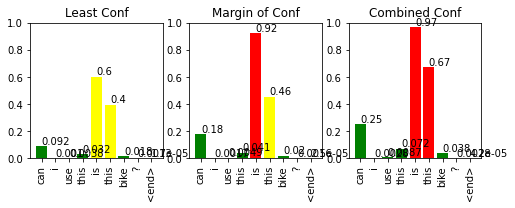

In [ ]:
# here we see the 'may' vs. 'can' uncertainty, depending on the training 
print("Target: Can I use this bike?") 
translate(u'מותר לי להשתמש באופניים?')

Target: Is anything wrong?

Input: <start> משהו לא בסדר ? <end>
Predicted translation: is anyone wrong ? <end> 
Runner-up translation: did she ok wrong ? 


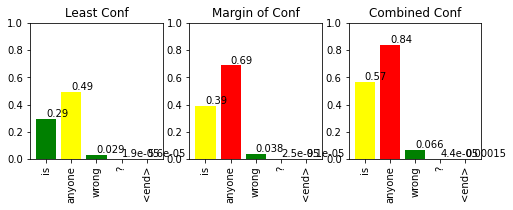

In [ ]:
#"Anything" vs. "something" vs. "anyone" uncertainty 
print("Target: Is anything wrong?")
translate(u'משהו לא בסדר?')

Target: Is this our flight?

Input: <start> זאת הטיסה שלנו ? <end>
Predicted translation: is this our flight ? <end> 
Runner-up translation: are that car canadian for ? 


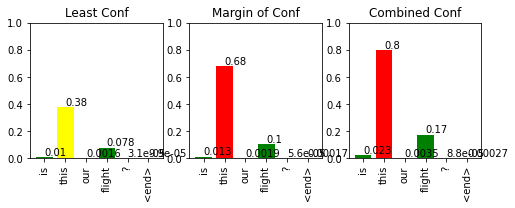

In [ ]:
 # note the "this" versus "that" uncertainty.  In my run it got "Is this our book" but "book" has very high uncertainty
 print("Target: Is this our flight?")
 translate(u'זאת הטיסה שלנו?')

Target: Stop grumbling.

Input: <start> תפסיק להתלונן . <end>
Predicted translation: stop grumbling . <end> 
Runner-up translation: quit interfering down mary 


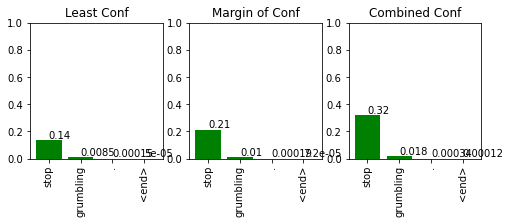

In [ ]:
# "grumbling" vs. "complaining" uncertainty sometimes, "quit" vs. "stop" other times
print("Target: Stop grumbling.")
translate(u'תפסיק להתלונן.')



Target: Do you see it?

Input: <start> אתה רואה את זה ? <end>
Predicted translation: do you see it ? <end> 
Runner-up translation: did see remember this for them 


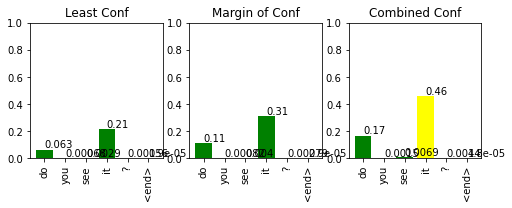

In [ ]:
#"it" versus "that", or "do" vs. <empty>
print("Target: Do you see it?")
translate(u'אתה רואה את זה?')

Target: My cat loves toys.

Input: <start> החתול שלי אוהב צעצועים <end>
Predicted translation: my cat loves toys . <end> 
Runner-up translation: a food likes white cold super 


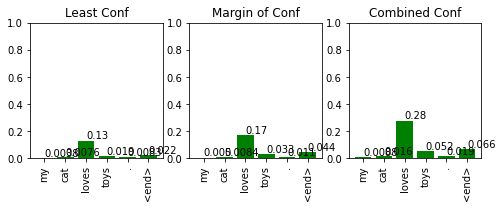

In [ ]:
print("Target: My cat loves toys.")
translate(u'החתול שלי אוהב צעצועים')

In [133]:
#print("Target: If someone who doesn't know your background says that you sound like a native speaker, it means they probably noticed something about your speaking that made them realize you weren't a native speaker. In other words, you don't really sound like a native speaker.")
#translate(u'אם מישהו שאינו מכיר את הרקע שלכם אומר שאתם נשמעים כמו דוברים ילידים , פירוש הדבר שהוא מן הסתם הבחין במשהו בדיבורכם שגרם לו להבין שאינכם דוברים ילידים . במילים אחרות , אתם לא באמת נשמעים כמו דוברים ילידים .')


##Towards Uncertainty (and Certainty) Sampling
Now that we've seen some interesting values for individual translation tokens, we're ready to approach some uncertainty sampling using an aggregation across the entire sequence.

Let's just start with the admittedly arbitrary guess-timated thresholds below
and equally sized subsets of both our training and validation sets for testing against these thresholds.  We do want to choose these thresholds in a more sophisticated way, but for now it will do for exploration.

In [ ]:
total_test_size=1000
uncertainty_sampling_treshold = 0.2
certainty_sampling_treshold = 0.02

In [ ]:
#Some table-setting functions we'll need:

def convert_to_sentence(lang, tensor):
  sentence = "";
  for t in tensor:
    if t not in [0, 1, 2]:
      sentence = sentence + ' ' + lang.index_word[t]
  return sentence

def translate_sentences(inp_lang, targ_lang, input_tensor, target_tensor, range, verbose=True):
  scores = []
  results = []
  for s in range:
    input_sentence = convert_to_sentence(inp_lang, input_tensor[s])
    target_sentence = convert_to_sentence(targ_lang, target_tensor[s])
    if verbose:
      print("\n\nSentence: " + input_sentence)
      print("Target: " + target_sentence)
    score, result = translate(input_sentence, verbose)
    scores.append(score)
    results.append(result)
  return np.array(scores), np.array(results)



In [ ]:
def get_high_uncertainty_sample_size(sequence_mean, threshold = uncertainty_sampling_treshold):
  mask_uncertainty = sequence_mean > threshold
  uncertainty_sample = sequence_mean[mask_uncertainty]
  uncertainty_sample_size = len(uncertainty_sample)
  print("Uncertainty set size: " + str(uncertainty_sample_size) + " out of " + str(len(sequence_mean)))
  return uncertainty_sample_size

def get_low_uncertainty_sample_size(sequence_mean, threshold = certainty_sampling_treshold):
  mask_uncertainty = sequence_mean <= threshold
  certainty_sample = sequence_mean[mask_uncertainty]
  certainty_sample_size = len(certainty_sample)
  print("Certainty subset size: " + str(certainty_sample_size) + " out of " + str(len(sequence_mean)))
  return certainty_sample_size

Depending on the size of the test (above) the two cells below  may take a minute or two each for 1000 translations on a GPU.   

In [ ]:
train_score_plots, training_results = translate_sentences(inp_lang, targ_lang, input_tensor_train, target_tensor_train, range(total_test_size), verbose=False)
train_set_mean = tf.math.reduce_mean(train_score_plots, axis=[0,1])
print("Training set uncertainty means: " + str(train_set_mean.numpy()))
training_sequences_means = tf.math.reduce_mean(train_score_plots[:,:,-1], axis=1).numpy() #sequence mean as our sample aggregation function TODO consider using minimum
training_high_uncertainty_sample_size = get_high_uncertainty_sample_size(training_sequences_means)
training_low_uncertainty_sample_size = get_low_uncertainty_sample_size(training_sequences_means)

Training set uncertainty means: [0.0309486  0.04797889 0.06322743]
Uncertainty set size: 29 out of 1000
Certainty subset size: 279 out of 1000


In [ ]:
val_score_plots, val_results = translate_sentences(inp_lang, targ_lang, input_tensor_val, target_tensor_val, range(total_test_size), verbose=False)
val_set_mean = tf.math.reduce_mean(val_score_plots, axis=[0,1])
print("Validation set uncertainty means: " + str(val_set_mean.numpy()))
val_sequences_means = tf.math.reduce_mean(val_score_plots[:,:,-1], axis=1).numpy() #sequence mean as our sample aggregation function
val_high_uncertainty_sample_size = get_high_uncertainty_sample_size(val_sequences_means)
val_low_uncertainty_sample_size = get_low_uncertainty_sample_size(val_sequences_means)


Validation set uncertainty means: [0.08398382 0.11752712 0.14158865]
Uncertainty set size: 231 out of 1000
Certainty subset size: 60 out of 1000


Not surprisingly:
* the overall uncertainty means across all three measures are higher for the validation set
* the "certain" cohort is larger for the training set versus the validation set.

A little more suprisingly:
* while the above remains true, for the same thresholds, different "slices" of 1000 out of our total training and validation sets can yield different total #'s and 'uncertain' vs. 'certain' cohorts.  We'll explore that below.

### Exploring Underfitting and (Un)certainty
So to look for avoidable bias (underfitting), now let's take a look at which of our confident mis-matches (at least according to our crude 1-1 matching algorithm with no alternate reference translations considered):

In [179]:

def get_ranked_uncertainty(sequences_means, size, target_tensor=None, input_tensor=None, 
                           direction='DESCENDING', display=True, ranking=None, results=None,  targ_lang=targ_lang):
  matches = []
  non_matches = []
  if ranking is None:
    ranking = tf.argsort(sequences_means, direction=direction)
  for u in range(size):
    #print(ranking[u]) 
    target = convert_to_sentence(targ_lang, target_tensor[ranking[u]])
    #print("\n\nTarget: " + target)
    if display:
      print("\n\nTarget: " + target)
      print("Aggregate Sequence Uncertainty: " + str(sequences_means[ranking[u]]))
      translate(convert_to_sentence(inp_lang, input_tensor[ranking[u]]))
    else:
      tokenized_result = results[ranking[u]] #_, tokenized_result = translate(convert_to_sentence(inp_lang, input_tensor[ranking[u]]), verbose=False)
      if "<end>" in tokenized_result:
        tokenized_result.remove('<end>')
      if ' '.join(tokenized_result).strip() == target.strip():
        matches.append(ranking[u])
      else:
        #print(' '.join(tokenized_result).strip()) #- if you want to display the non-match inline
        #print(target.strip())
        non_matches.append(ranking[u])
  return np.array(matches), np.array(non_matches)


In [156]:
training_matches, training_non_matches = get_ranked_uncertainty(training_sequences_means, training_low_uncertainty_sample_size, target_tensor_train,
                                              direction='ASCENDING', display=False, results=training_results)
#print(training_matches[-1])
print("Training set confident matches: " + str(len(training_matches)))
print("Training set confident non-Matches: " + str(len(training_non_matches)))
print("Matching: {:.1%}".format((len(training_matches)/(len(training_matches)+len(training_non_matches)))))

273
Training set confident matches: 275
Training set confident non-Matches: 4
Matching: 98.6%


Yay!  A high percentage of matches (accuracy) in the large highly confident set is what we like to see.  Let's look at the non-matches:



Target:  we're dedicated .
Aggregate Sequence Uncertainty: 0.0016303420066833495

Input: <start> אנו מסורים . <end>
Predicted translation: we're committed . <end> 
Runner-up translation: everybody's dedicated ? them 


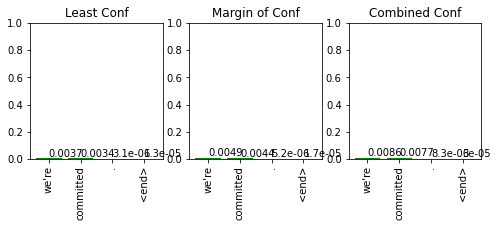



Target:  tom was stunned .
Aggregate Sequence Uncertainty: 0.012990474700927734

Input: <start> תום היה המום . <end>
Predicted translation: tom was shocked . <end> 
Runner-up translation: tom's is stunned shocked yourselves 


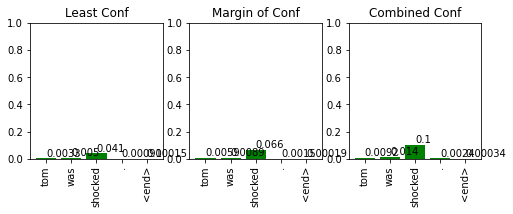



Target:  i still love it .
Aggregate Sequence Uncertainty: 0.013669610023498535

Input: <start> אני עדיין אוהבת אותה . <end>
Predicted translation: i still love her . <end> 
Runner-up translation: i'm am like it , them 


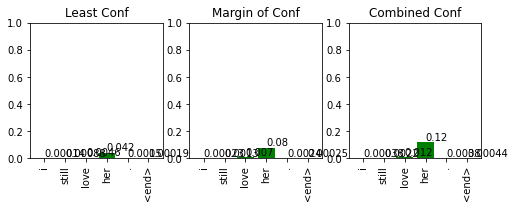



Target:  tom was selected .
Aggregate Sequence Uncertainty: 0.014226430654525756

Input: <start> תום נבחר . <end>
Predicted translation: tom was elected . <end> 
Runner-up translation: tom's is alerted ? tom 


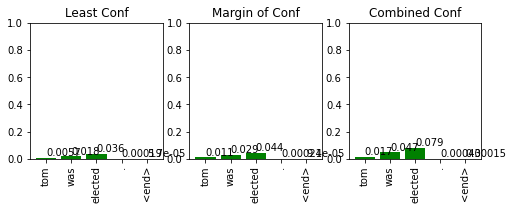

(array([], dtype=float64), array([], dtype=float64))

In [ ]:
get_ranked_uncertainty(training_sequences_means, len(training_non_matches), target_tensor_train, 
                       input_tensor=input_tensor_train, ranking=training_non_matches, results=training_results)

OK!  Some of these departures from the strict ground truth would probably qualify as alternate reference translations, if we're doing proper accuracy scoring.  (There also seems to be an issue where the model doesn't "know" that it has an issue with tense, so there's an area to target for underfitting.)  

Overall, for our set of sentences with a high "certainty" threshold of 0.02, the size can range widely from 28% to just over 63% of the training set!.  But no matter its size (keep in mind this is so far a fairly arbitrary threshold( we are pretty close to fully fitting.  

Before we get too full of ourselves and forget what we're really after in an Active Learning cycle, let's look at the least confident ones, and along the way try to find some examples of underfitting:




In [ ]:
training_unsure_matches, training_unsure_non_matches = get_ranked_uncertainty(training_sequences_means, training_high_uncertainty_sample_size, target_tensor_train,
                                              display=False, results=training_results)
print("Training set highly non-confident matches: " + str(len(training_unsure_matches)))
print("Training set highly non-confident non-Matches: " + str(len(training_unsure_non_matches)))

Training set highly non-confident matches: 6
Training set highly non-confident non-Matches: 23




Target:  how's the job hunt ?
Aggregate Sequence Uncertainty: 0.6450103304872755

Input: <start> איך חיפוש העבודה שלך מתקדם ? <end>
Predicted translation: how did i do i do i do i do 
Runner-up translation: how's is we park we hunt ? hunt ? hunt 


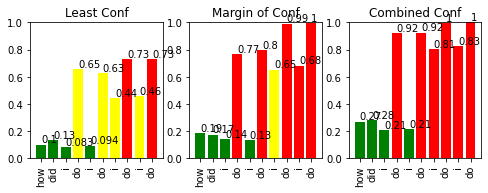



Target:  i've got diarrhea .
Aggregate Sequence Uncertainty: 0.4624363790731877

Input: <start> אני סובלת משלשול . <end>
Predicted translation: i have to the guest . <end> 
Runner-up translation: i've took diarrhea focus heart off . 


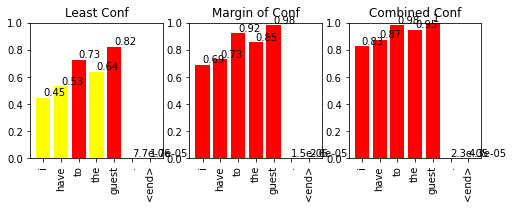



Target:  why is it so hot ?
Aggregate Sequence Uncertainty: 0.30353569476865233

Input: <start> למה חם כל כך ? <end>
Predicted translation: where is it so hot ? <end> 
Runner-up translation: why does that hot ? so ? 


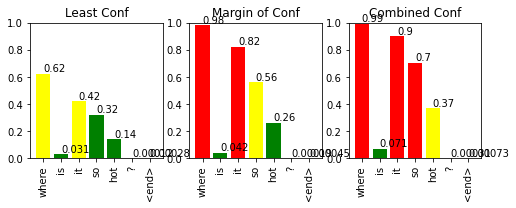



Target:  that guy annoys me .
Aggregate Sequence Uncertainty: 0.2877343898639083

Input: <start> הבחור הזה מעצבן אותי . <end>
Predicted translation: this lake annoys me . <end> 
Runner-up translation: that guy annoying music ! me 


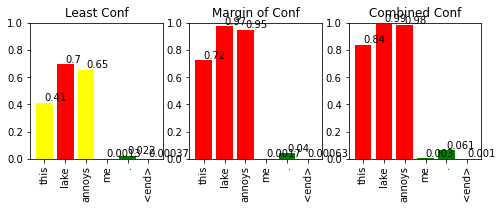



Target:  switch it on .
Aggregate Sequence Uncertainty: 0.2818513872101903

Input: <start> תחבר את זה . <end>
Predicted translation: pick this book . <end> 
Runner-up translation: switch that on out that 


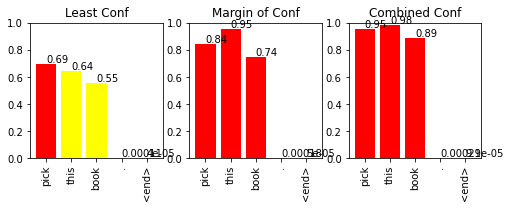



Target:  the black dog ran .
Aggregate Sequence Uncertainty: 0.27800681805238125

Input: <start> הכלב השחור רץ . <end>
Predicted translation: the dog is running . <end> 
Runner-up translation: a black ran fast low super 


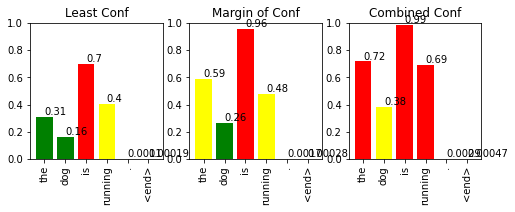



Target:  he's not in .
Aggregate Sequence Uncertainty: 0.27780635859817265

Input: <start> הוא איננו כאן . <end>
Predicted translation: he is not in . <end> 
Runner-up translation: he's isn't still here here ! 


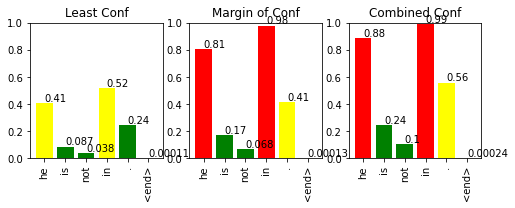



Target:  we deserved it .
Aggregate Sequence Uncertainty: 0.27612706907093526

Input: <start> זה מגיע לנו . <end>
Predicted translation: we deserve for us . <end> 
Runner-up translation: they deserved the you ? me 


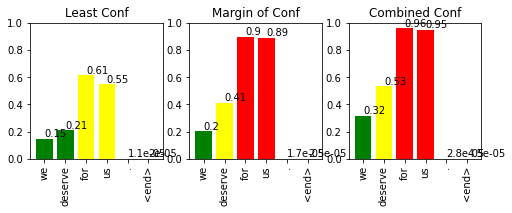



Target:  please hurry up !
Aggregate Sequence Uncertainty: 0.2732103019952774

Input: <start> נו כבר ! <end>
Predicted translation: come on , please ! <end> 
Runner-up translation: please up it ! . ! 


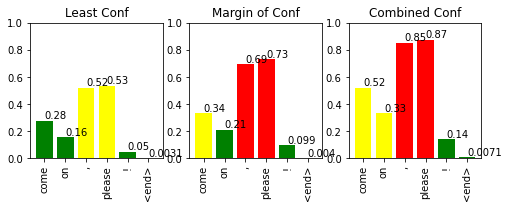



Target:  i'm earning money .
Aggregate Sequence Uncertainty: 0.2700416173785925

Input: <start> אני מרוויחה כסף . <end>
Predicted translation: i get paid money . <end> 
Runner-up translation: i'm say money . time that 


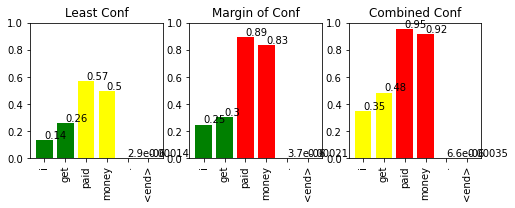



Target:  copy this , please .
Aggregate Sequence Uncertainty: 0.25601961007341745

Input: <start> תעתיק את זה בבקשה . <end>
Predicted translation: please wrap it . <end> 
Runner-up translation: copy fix this , me 


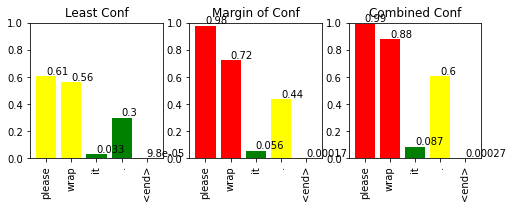



Target:  nobody said that .
Aggregate Sequence Uncertainty: 0.2509096972644329

Input: <start> איש לא אמר את זה . <end>
Predicted translation: no one knew it . <end> 
Runner-up translation: nobody weapon said that ! it 


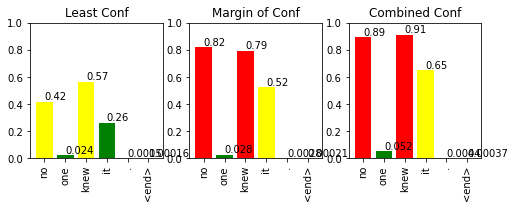



Target:  he's coming .
Aggregate Sequence Uncertainty: 0.24745916556566955

Input: <start> הנה הוא בא . <end>
Predicted translation: here he comes . <end> 
Runner-up translation: he's comes is off . 


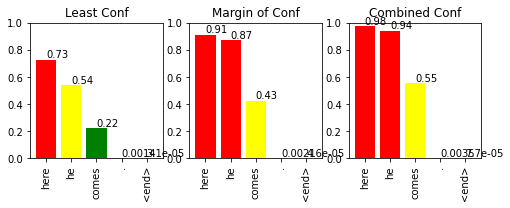



Target:  tom was unharmed .
Aggregate Sequence Uncertainty: 0.24328402066603302

Input: <start> תום לא נפגע . <end>
Predicted translation: tom is not hurt . <end> 
Runner-up translation: tom's was unarmed scared ? tom 


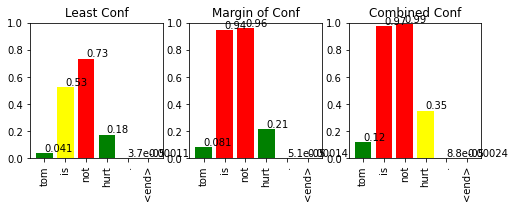



Target:  do you have it ?
Aggregate Sequence Uncertainty: 0.24232684820890427

Input: <start> זה ברשותך ? <end>
Predicted translation: do you have them ? <end> 
Runner-up translation: did they let it it them 


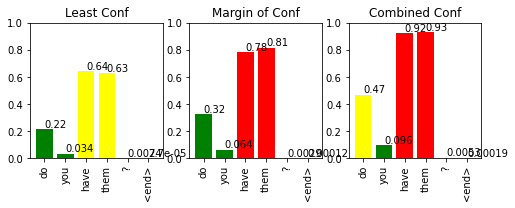



Target:  i ate on the bus .
Aggregate Sequence Uncertainty: 0.2378411039710045

Input: <start> אכלתי באוטובוס . <end>
Predicted translation: i quickly on the bus . <end> 
Runner-up translation: i've ate ate a nail out me 


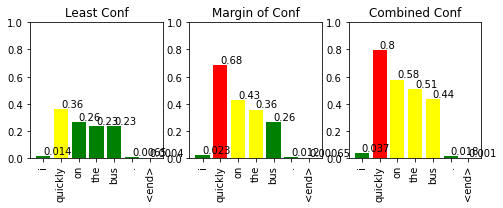



Target:  walk tall , son .
Aggregate Sequence Uncertainty: 0.23592532631009816

Input: <start> תהלך זקוף , בני . <end>
Predicted translation: try any shot . <end> 
Runner-up translation: now tall week , . 


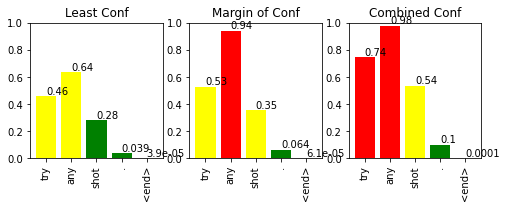



Target:  my feet get cold .
Aggregate Sequence Uncertainty: 0.23290872275829316

Input: <start> כפות הרגליים שלי נוטות להתקרר . <end>
Predicted translation: my feet like cold . <end> 
Runner-up translation: i sister cold my ? super 


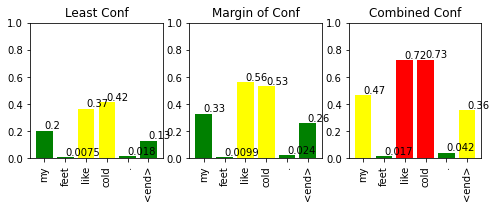



Target:  i was unfair .
Aggregate Sequence Uncertainty: 0.21749487705528736

Input: <start> זה לא היה הוגן . <end>
Predicted translation: it wasn't unfair . <end> 
Runner-up translation: that was fair ? i 


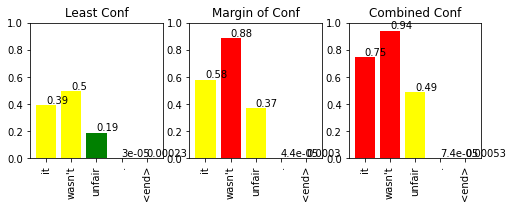



Target:  he's a florist .
Aggregate Sequence Uncertainty: 0.2157793041318655

Input: <start> הוא מוכר פרחים . <end>
Predicted translation: he's old flowers . <end> 
Runner-up translation: he a piano bloomer fuji 


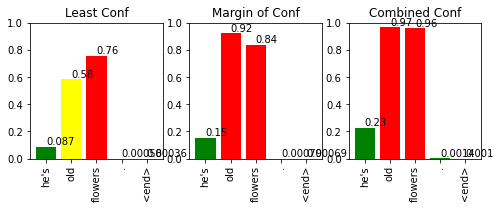



Target:  i don't know yet .
Aggregate Sequence Uncertainty: 0.2102352909743786

Input: <start> איני יודע עדיין . <end>
Predicted translation: i still don't know . <end> 
Runner-up translation: i'm know not live yet super 


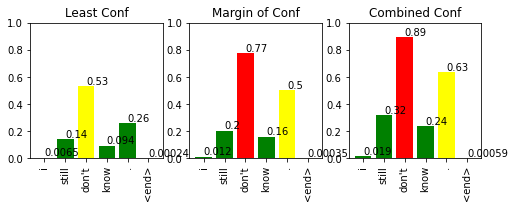



Target:  have fun .
Aggregate Sequence Uncertainty: 0.20388813652098178

Input: <start> תיהני ! <end>
Predicted translation: beat it . <end> 
Runner-up translation: have me ! ! 


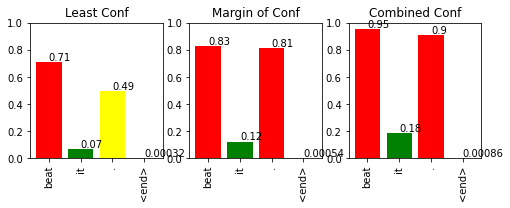



Target:  who was it ?
Aggregate Sequence Uncertainty: 0.20008006393909455

Input: <start> מי זה היה ? <end>
Predicted translation: whose was it ? <end> 
Runner-up translation: who one that was ? 


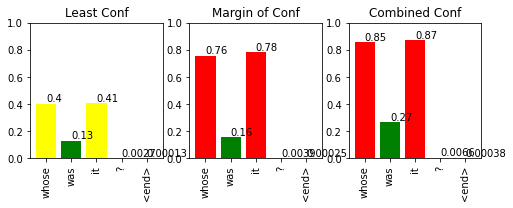

(array([], dtype=float64), array([], dtype=float64))

In [ ]:
get_ranked_uncertainty(training_sequences_means, len(training_unsure_non_matches), target_tensor_train, 
                       input_tensor=input_tensor_train, ranking=training_unsure_non_matches, results=training_results)

Alright, a few issues here among the low certainty cohort.  Not all of these are bad translations in my run e.g. in my set "He's not home" becomes "He isn't at home", or "Let me out!" becomes "I want to leave!" 

Its interesting to note sometimes which individual words/tokens will have high uncertainty, often indicating where the translation went awry.  This could be of help for humans in the loop correcting these translations, for example. 

But let's be hard on ourselves and assume they're all one way or another examples of underfitting - at least finding them by means of low aggregate uncertainty ranking.  Now we'd have to candidates for an Active Learning cycle.  Also, playing with the thresholds (and ultimately, optimizing them) would be the next thing to try in future cycles.  But let's move on to the validation set.

### Exploring Variance and (Un)certainty


Previously we saw that the validation results had fewer high confidence examples.  Let's start by looking at those:


In [52]:
val_conf_matches, val_conf_non_matches = get_ranked_uncertainty(val_sequences_means, val_low_uncertainty_sample_size, target_tensor_val,
                                              direction='ASCENDING', display=False, results=val_results)
print("Validation set confident matches: " + str(len(val_conf_matches)))
print("Validation set confident non-matches: " + str(len(val_conf_non_matches)))
print("Matching: {:.1%}".format((len(val_conf_matches)/(len(val_conf_matches)+len(val_conf_non_matches)))))

Validation set confident matches: 43
Validation set confident non-matches: 17
Matching: 71.7%


Usually we have fewer overall high-certainty results from the validation set compared with the training set (using the same threshold as training). (However, some n-1000 test batches I've run happen to match or even exceed the training set!) 

It's also not surprising that we have a higher number of confident non-Matches.  As we did before, let's check out those high certainty non-matches:



Target:  we're stunned .
Aggregate Sequence Uncertainty: 0.002335631847381592

Input: <start> אנחנו המומים . <end>
Predicted translation: we're shocked . <end> 
Runner-up translation: everyone's stunned shocked . 


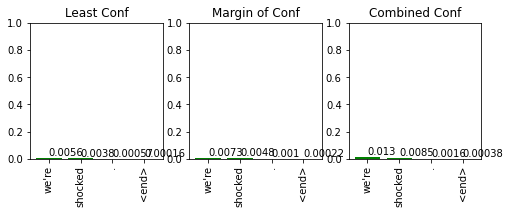



Target:  you have been busy .
Aggregate Sequence Uncertainty: 0.005369889736175537

Input: <start> היית עסוק . <end>
Predicted translation: you were busy . <end> 
Runner-up translation: you're been happy ? super 


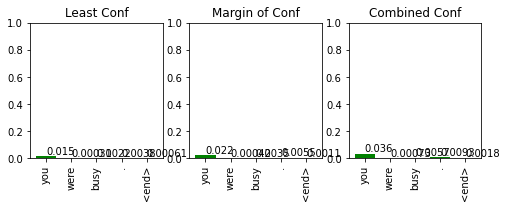



Target:  i'm scared .
Aggregate Sequence Uncertainty: 0.005630552768707275

Input: <start> אני חוששת . <end>
Predicted translation: i'm afraid . <end> 
Runner-up translation: i persevering ! i 


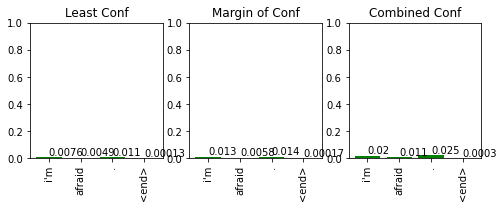



Target:  i need to relax .
Aggregate Sequence Uncertainty: 0.00616602897644043

Input: <start> אני זקוק להתרגעות . <end>
Predicted translation: i need to unwind . <end> 
Runner-up translation: i've needed a quit thing them 


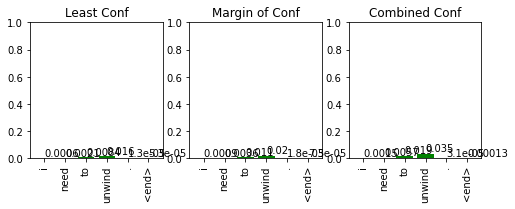



Target:  i'm devastated .
Aggregate Sequence Uncertainty: 0.00940002202987671

Input: <start> אני הרוסה . <end>
Predicted translation: i'm ruined . <end> 
Runner-up translation: i getting off . 


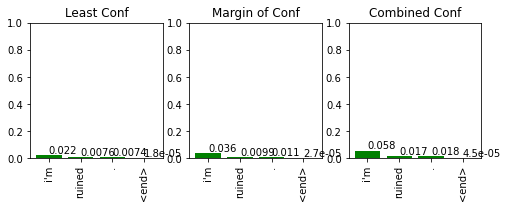



Target:  you're harsh .
Aggregate Sequence Uncertainty: 0.010174626111984253

Input: <start> אתם קשוחים . <end>
Predicted translation: you're tough . <end> 
Runner-up translation: i'm harsh ! super 


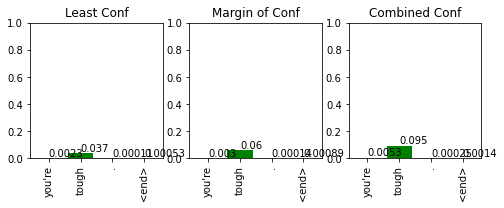



Target:  grab the rope .
Aggregate Sequence Uncertainty: 0.011364078521728516

Input: <start> אחוז בחבל . <end>
Predicted translation: hold the rope . <end> 
Runner-up translation: pull on line the . 


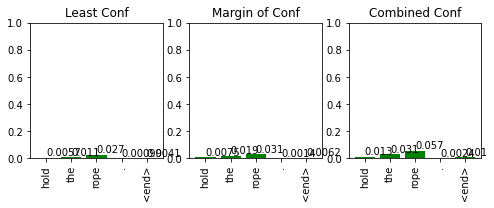



Target:  let me pay .
Aggregate Sequence Uncertainty: 0.01160978078842163

Input: <start> אני אשלם . <end>
Predicted translation: i'll pay . <end> 
Runner-up translation: i call from i 


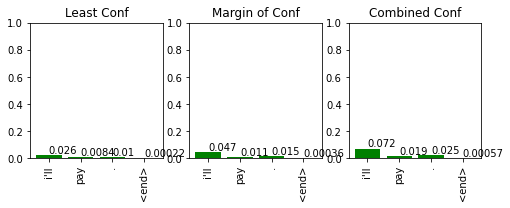



Target:  i'm curious .
Aggregate Sequence Uncertainty: 0.01199374794960022

Input: <start> אני מסוקרן . <end>
Predicted translation: i'm intrigued . <end> 
Runner-up translation: i involved in . 


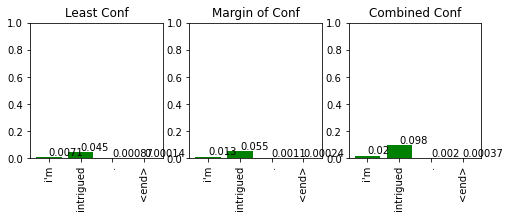



Target:  we're always happy .
Aggregate Sequence Uncertainty: 0.014302551746368408

Input: <start> אנו תמיד מאושרים . <end>
Predicted translation: we always happy . <end> 
Runner-up translation: we're might stay high . 


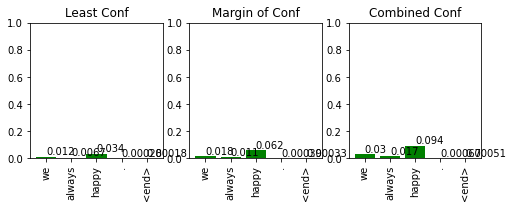



Target:  i know you're mad .
Aggregate Sequence Uncertainty: 0.015623682737350464

Input: <start> אני יודע שאת משוגעת . <end>
Predicted translation: i know you're nuts . <end> 
Runner-up translation: i'm knows her mad it . 


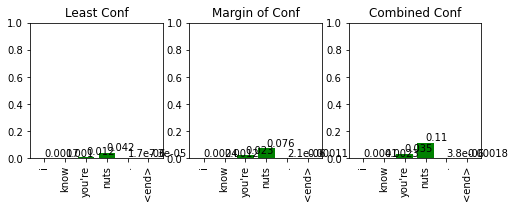



Target:  i try .
Aggregate Sequence Uncertainty: 0.01648784875869751

Input: <start> אני מנסה . <end>
Predicted translation: i'm trying . <end> 
Runner-up translation: i diligent is yourself 


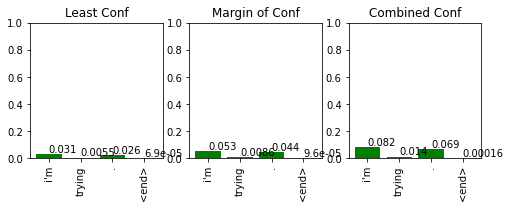



Target:  those are good .
Aggregate Sequence Uncertainty: 0.01659001111984253

Input: <start> אלה טובים . <end>
Predicted translation: these are good . <end> 
Runner-up translation: everything is beautiful good . 


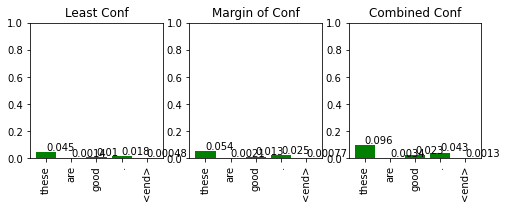



Target:  i saw him go out .
Aggregate Sequence Uncertainty: 0.017175859212875365

Input: <start> ראיתי אותו יוצא . <end>
Predicted translation: i saw him go . <end> 
Runner-up translation: i've call it to away i 


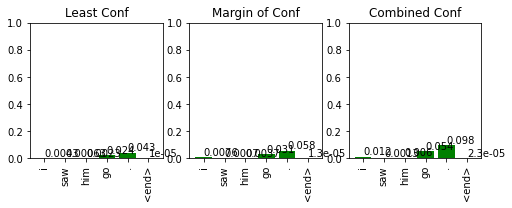



Target:  i'm embarrassed .
Aggregate Sequence Uncertainty: 0.017506319284439086

Input: <start> אני במבוכה . <end>
Predicted translation: i am embarrassed . <end> 
Runner-up translation: i'm feel angry trouble super 


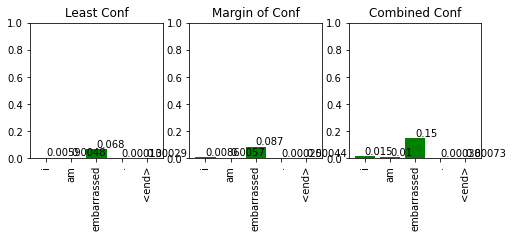



Target:  it was enticing .
Aggregate Sequence Uncertainty: 0.017826169729232788

Input: <start> זה היה מפתה . <end>
Predicted translation: it was tempting . <end> 
Runner-up translation: that were exhilarating it them 


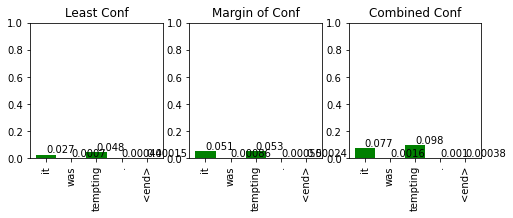



Target:  you're timid .
Aggregate Sequence Uncertainty: 0.01865442395210266

Input: <start> אתם ביישנים . <end>
Predicted translation: you're shy . <end> 
Runner-up translation: you courageous ? . 


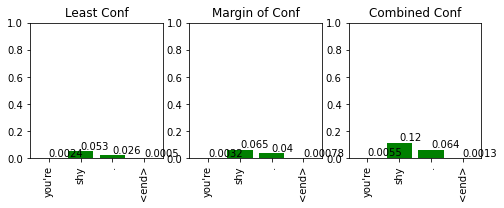

(array([], dtype=float64), array([], dtype=float64))

In [53]:
get_ranked_uncertainty(val_sequences_means, len(val_conf_non_matches), target_tensor_val, 
                       input_tensor=input_tensor_val, ranking=val_conf_non_matches, results=val_results)

The majority of these are decent alternate translations, and again uncovers issues where MT result is better than the "ground truth" e.g. in my set the translation "i'm here" is better than "I'm in here". So, it's kind of cool to see it generalizing in a correct way. We'll explore this more below. 

Let's look at the much larger least confident cohort:

In [54]:
val_unsure_matches, val_unsure_non_matches = get_ranked_uncertainty(val_sequences_means, val_high_uncertainty_sample_size, target_tensor_val,
                                              display=False, results=val_results)
print("Validation set highly non-confident matches: " + str(len(val_unsure_matches)))
print("Validation set highly non-confident non-Matches: " + str(len(val_unsure_non_matches)))
print("Matching: {:.1%}".format(len(val_unsure_matches)/(len(val_unsure_matches)+len(val_unsure_non_matches))))

Validation set highly non-confident matches: 3
Validation set highly non-confident non-Matches: 228
Matching: 1.3%


In [ ]:
get_ranked_uncertainty(val_sequences_means, len(val_unsure_non_matches), target_tensor_val, 
                       input_tensor=input_tensor_val, ranking=val_unsure_non_matches, results=val_results)

Wow!  Pretty bad stuff there - but that was exactly what we were looking for as candidates for a first pass in an Active Learning cycle.  Also, it shows that the model is aware of its "known unknowns".  Finally, let's touch on the overall look of the validation set apart from the high uncertainty set:

In [55]:
val_matches, val_non_matches = get_ranked_uncertainty(val_sequences_means, total_test_size-val_high_uncertainty_sample_size, target_tensor_val,
                                              direction='ASCENDING', display=False, results=val_results)
print("Validation set less confused matches: " + str(len(val_matches)))
print("Validation set less confused non-Matches: " + str(len(val_non_matches)))
print("Matching: {:.1%}".format((len(val_matches)/(len(val_matches)+len(val_non_matches)))))

Validation set less confused matches: 231
Validation set less confused non-Matches: 538
Matching: 30.0%


In various runs, I range from about 25% to even 75% matching, and therefore known to be accurate - much better than our highly uncertain set.  And of course, many of these non-matches may be viable translations.  Exploring and optimizing the thresholds should help, so let's try a different way of discovering non-matches (and, among those, errors) than just a single threshold:

##Confirming that Scores do successfully model Accuracy Confidence

So our thresholds we chose to do some exploratory analysis were arbitrary:

In [56]:
import scipy as sp
high_uncertainty_threshold_percentile = sp.stats.percentileofscore(val_sequences_means, uncertainty_sampling_treshold)
print ("Percentile of our high uncertainty threshold for validation scores: " + str(high_uncertainty_threshold_percentile))

Percentile of our high uncertainty threshold for validation scores: 76.9


Let's try to do a more formal job in exploring uncertainty as a predictor for potential errors, using a range percentile thresholds instead:

In [91]:
val_total_matches, val_total_non_matches = get_ranked_uncertainty(val_sequences_means, total_test_size, target_tensor_val,
                                              direction='ASCENDING', display=False, results=val_results)
print("Total Validation set matches: " + str(len(val_total_matches)))
print("Validation set non-Matches: " + str(len(val_total_non_matches)))
print("Matching: {:.1%}".format((len(val_total_matches)/(len(val_total_matches)+len(val_total_non_matches)))))

Total Validation set matches: 234
Validation set non-Matches: 766
Matching: 23.4%


Depending on the validatio set, non-match percentages can vary widely, both very much above and very much below 50%.  If much above 50%, non-matches will tend to be concentrated in the high-uncertainty percentiles much more than if not.  If below 50%, we'll want to still use analysis sampling from different percentile ranges.  

In [196]:
def find_uncertainty_predictivity(percentile=90): #higher the percentile, higher the uncertainty
  percentile_threshold = np.percentile(val_sequences_means, percentile)
  print("Percentile score threshold: " + str(percentile_threshold))
  #first_decile = [v for v in val_sequences_means if v <= tenth_percentile]
  percentile_len = total_test_size*(100-percentile)//100
  #print(val_sequences_means)

  val_percentile_matches, val_percentile_non_matches = get_ranked_uncertainty(val_sequences_means, percentile_len, target_tensor_val, 
                       input_tensor=input_tensor_val, direction='DESCENDING', display=False, results=val_results)
  print("Matches for the " + str(percentile) + "th percentile: " + str(len(val_percentile_matches)))
  print("Non-Matches for the " + str(percentile) + "th percentile: " + str(len(val_percentile_non_matches)))
  print("Non-Matching: {:.1%}".format((len(val_percentile_non_matches)/(len(val_percentile_matches)+len(val_percentile_non_matches)))))
  print("\033[1m{:.1%}\033[0m".format(len(val_percentile_non_matches)/(len(val_total_non_matches))) +
        " of the potential errors are found by \033[1m{:.1%}\033[0m".format((100-percentile)/100) +
        " of the target sentences with the highest uncertainty score.")
  #return val_percentile_matches, val_percentile_non_matches

So now we have our validation set matches, (i.e. known to be accurate because the match), and non-matches (potential errors in prediction). Let's try to find out how uncertainty scoring can predict the non-matches, (and therefore, potential errors), by stepping 10 percentiles (deciles):

In [197]:
find_uncertainty_predictivity(90)

Percentile score threshold: 0.26014740819577126
Matches for the 90th percentile: 0
Non-Matches for the 90th percentile: 100
Non-Matching: 100.0%
13.1% of the potential errors are found by 10.0% of the target sentences with the highest uncertainty score.


In [199]:
find_uncertainty_predictivity(80)

Percentile score threshold: 0.20923639148473744
Matches for the 80th percentile: 3
Non-Matches for the 80th percentile: 197
Non-Matching: 98.5%
25.7% of the potential errors are found by 20.0% of the target sentences with the highest uncertainty score.


In [200]:
find_uncertainty_predictivity(70)

Percentile score threshold: 0.18652790804393587
Matches for the 70th percentile: 10
Non-Matches for the 70th percentile: 290
Non-Matching: 96.7%
37.9% of the potential errors are found by 30.0% of the target sentences with the highest uncertainty score.


In [201]:
find_uncertainty_predictivity(20)

Percentile score threshold: 0.06245065212249756
Matches for the 20th percentile: 120
Non-Matches for the 20th percentile: 680
Non-Matching: 85.0%
88.8% of the potential errors are found by 80.0% of the target sentences with the highest uncertainty score.


In [202]:
find_uncertainty_predictivity(10)

Percentile score threshold: 0.033440956473350526
Matches for the 10th percentile: 171
Non-Matches for the 10th percentile: 729
Non-Matching: 81.0%
95.2% of the potential errors are found by 90.0% of the target sentences with the highest uncertainty score.


So it looks like the trend is clear, if not very dramatically in some sets, that the higher the uncertainty the higher the potential errors (mismatches to reference translation) 
Let's dive into sampling and look at the mismatches in different deciles:

In [205]:
def show_mismatches_in_percentile_range_results(low_percentile, high_percentile, number_to_display=None):
  low_percentile_threshold = np.percentile(val_sequences_means, low_percentile)
  high_percentile_threshold = np.percentile(val_sequences_means, high_percentile)
  print("Low Percentile score threshold: " + str(low_percentile_threshold))
  print("High Percentile score threshold: " + str(high_percentile_threshold))
  #print(len(val_sequences_means))
  percentile_results = [list(val_sequences_means).index(v) for v in val_sequences_means if v > low_percentile_threshold 
                                                                                        if v <= high_percentile_threshold]
  print(percentile_results)    
  #get_ranked_uncertainty(training_sequences_means, len(training_non_matches), target_tensor_train, 
  #                     input_tensor=input_tensor_train, ranking=training_non_matches, results=training_results)                                                            
  val_percentile_range_matches, val_percentile_range_non_matches = get_ranked_uncertainty(val_sequences_means, len(percentile_results), target_tensor_val, 
                       input_tensor=input_tensor_val, ranking=percentile_results, direction='DESCENDING', display=False, results=val_results)
  if not number_to_display:
    number_to_display = len(val_percentile_range_non_matches)
  get_ranked_uncertainty(val_sequences_means, number_to_display, target_tensor_val, 
                       input_tensor=input_tensor_val, ranking=val_percentile_range_non_matches, results=val_results)

**High Uncertainty -> Low Accuracy**:

Low Percentile score threshold: 0.26014740819577126
High Percentile score threshold: 0.48290872406214475
1000
[10, 47, 49, 51, 57, 58, 68, 74, 79, 86, 96, 100, 101, 116, 128, 168, 195, 207, 211, 251, 269, 272, 275, 276, 277, 283, 288, 310, 316, 322, 331, 342, 343, 352, 357, 388, 393, 400, 406, 411, 419, 421, 422, 426, 445, 455, 456, 460, 485, 486, 490, 512, 521, 530, 551, 558, 595, 599, 604, 606, 615, 618, 634, 643, 648, 656, 664, 693, 696, 697, 701, 710, 717, 720, 727, 738, 743, 752, 757, 762, 766, 768, 778, 782, 807, 814, 819, 86, 836, 845, 854, 857, 863, 874, 914, 939, 942, 982, 987, 996]


Target:  what's his name ?
Aggregate Sequence Uncertainty: 0.3629322718828917

Input: <start> איך קוראים לו ? <end>
Predicted translation: what does it have ? <end> 
Runner-up translation: what's is this hurt for them 


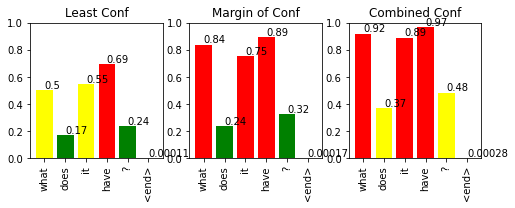



Target:  it is seven now .
Aggregate Sequence Uncertainty: 0.2660613875836134

Input: <start> עכשיו שבע . <end>
Predicted translation: it's up now . <end> 
Runner-up translation: now finished of off . 


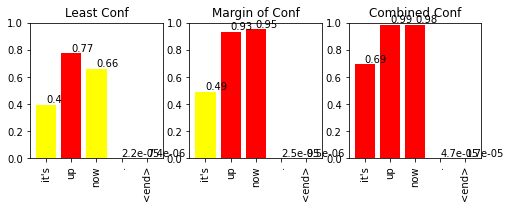



Target:  try not to cry .
Aggregate Sequence Uncertainty: 0.2951705233193934

Input: <start> תנסי לא לבכות . <end>
Predicted translation: try to hang up . <end> 
Runner-up translation: show some cry on down . 


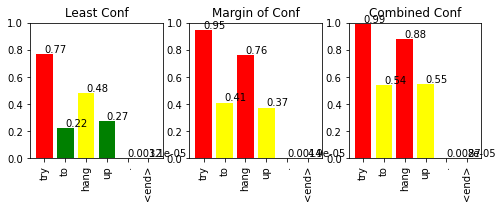



Target:  sign this .
Aggregate Sequence Uncertainty: 0.30040772184729575

Input: <start> תחתמו על זה . <end>
Predicted translation: turn it on this . <end> 
Runner-up translation: put over up . ? that 


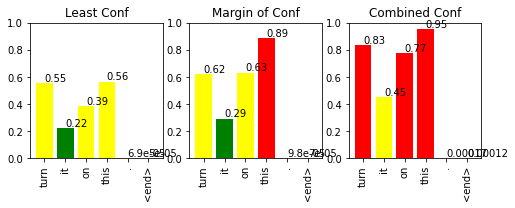



Target:  death is permanent .
Aggregate Sequence Uncertainty: 0.26828856920983524

Input: <start> המוות הוא נצחי . <end>
Predicted translation: trust is a fuss . <end> 
Runner-up translation: tomorrow for in metal off . 


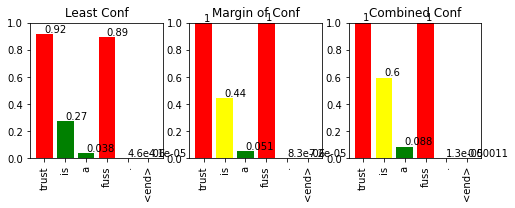

In [207]:
show_mismatches_in_percentile_range_results(90,100,5)

**Low Uncertainty -> High Accuracy (even if mismatched with reference translation)**

Low Percentile score threshold: 0.0019773602485656737
High Percentile score threshold: 0.033440956473350526
1000
[2, 30, 32, 34, 35, 41, 42, 43, 50, 65, 85, 89, 92, 99, 106, 119, 150, 152, 160, 174, 181, 188, 201, 236, 239, 240, 245, 267, 273, 290, 291, 293, 307, 326, 333, 341, 350, 359, 407, 412, 425, 440, 442, 450, 451, 453, 458, 461, 463, 495, 503, 510, 511, 520, 524, 531, 533, 537, 580, 581, 593, 597, 612, 617, 628, 629, 631, 651, 665, 680, 684, 737, 775, 781, 785, 803, 805, 812, 816, 824, 826, 843, 846, 847, 859, 868, 871, 890, 896, 899, 908, 924, 946, 958, 970, 975, 978, 997, 999]


Target:  those are good .
Aggregate Sequence Uncertainty: 0.01659001111984253

Input: <start> אלה טובים . <end>
Predicted translation: these are good . <end> 
Runner-up translation: everything is beautiful good . 


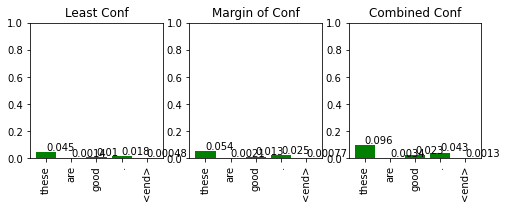



Target:  tom changed that .
Aggregate Sequence Uncertainty: 0.021425437927246094

Input: <start> תום שינה את זה . <end>
Predicted translation: tom rescheduled . <end> 
Runner-up translation: tom's changed that that 


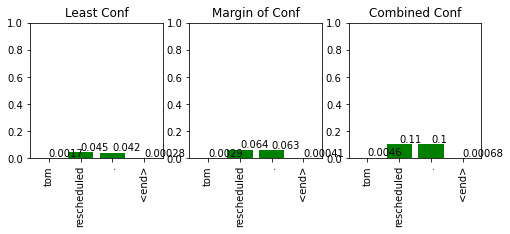



Target:  i'm curious .
Aggregate Sequence Uncertainty: 0.01199374794960022

Input: <start> אני מסוקרן . <end>
Predicted translation: i'm intrigued . <end> 
Runner-up translation: i involved in . 


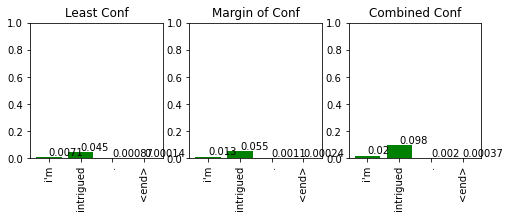



Target:  tom was shy .
Aggregate Sequence Uncertainty: 0.02459849715232849

Input: <start> תום היה ביישן . <end>
Predicted translation: tom was timid . <end> 
Runner-up translation: tom's is shy man . 


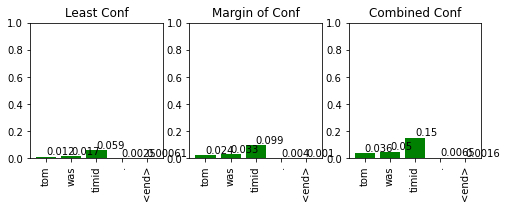



Target:  we're puzzled .
Aggregate Sequence Uncertainty: 0.02396872639656067

Input: <start> אנו מבולבלים . <end>
Predicted translation: we're confused . <end> 
Runner-up translation: everybody's embarrassed ? super 


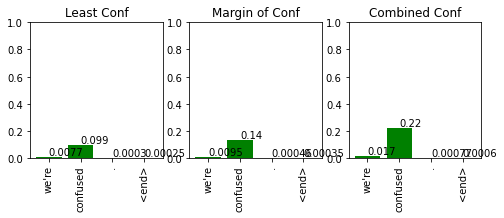



Target:  i'm scared .
Aggregate Sequence Uncertainty: 0.005630552768707275

Input: <start> אני חוששת . <end>
Predicted translation: i'm afraid . <end> 
Runner-up translation: i persevering ! i 


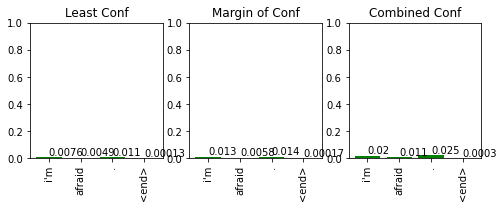



Target:  i saw him go out .
Aggregate Sequence Uncertainty: 0.017175859212875365

Input: <start> ראיתי אותו יוצא . <end>
Predicted translation: i saw him go . <end> 
Runner-up translation: i've call it to away i 


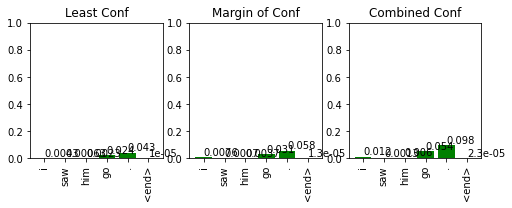



Target:  grab the rope .
Aggregate Sequence Uncertainty: 0.011364078521728516

Input: <start> אחוז בחבל . <end>
Predicted translation: hold the rope . <end> 
Runner-up translation: pull on line the . 


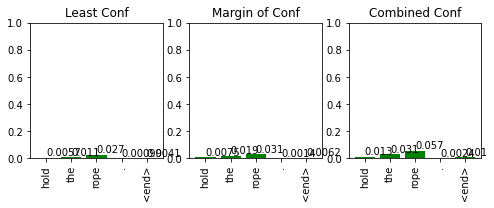



Target:  i'm able to swim .
Aggregate Sequence Uncertainty: 0.024473851919174193

Input: <start> אני מסוגל לשחות . <end>
Predicted translation: i can swim . <end> 
Runner-up translation: i'm could say well . 


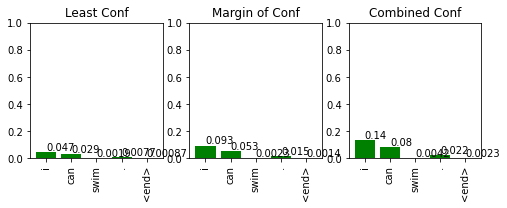



Target:  it was enticing .
Aggregate Sequence Uncertainty: 0.017826169729232788

Input: <start> זה היה מפתה . <end>
Predicted translation: it was tempting . <end> 
Runner-up translation: that were exhilarating it them 


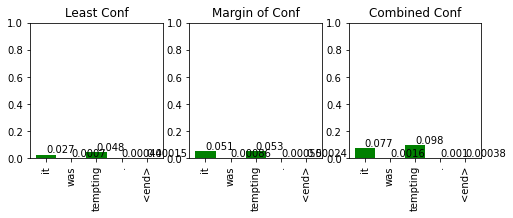



Target:  let me pay .
Aggregate Sequence Uncertainty: 0.01160978078842163

Input: <start> אני אשלם . <end>
Predicted translation: i'll pay . <end> 
Runner-up translation: i call from i 


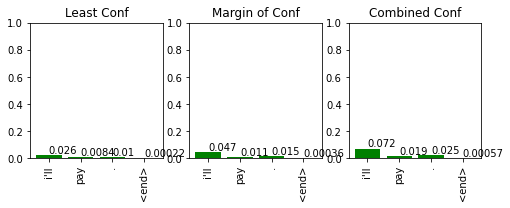



Target:  this is all i know .
Aggregate Sequence Uncertainty: 0.02431676983833313

Input: <start> זה כל מה שאני יודע . <end>
Predicted translation: that's all i know . <end> 
Runner-up translation: this how know do so . 


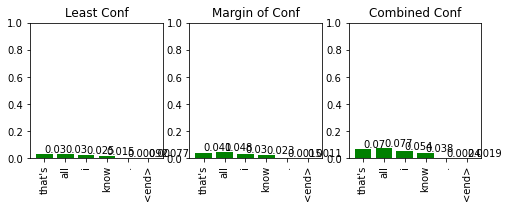



Target:  keep on smiling .
Aggregate Sequence Uncertainty: 0.02054755687713623

Input: <start> תמשיכי לחייך . <end>
Predicted translation: keep smiling . <end> 
Runner-up translation: let's reading off . 


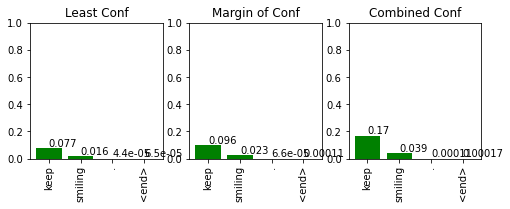



Target:  i'm reliable .
Aggregate Sequence Uncertainty: 0.024716806411743165

Input: <start> אני אמין . <end>
Predicted translation: i'm believable . <end> 
Runner-up translation: i discouraged down . 


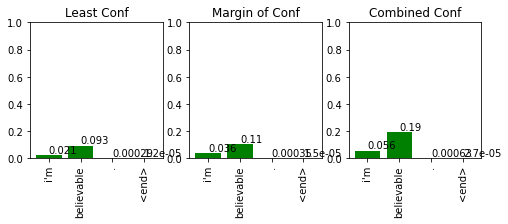



Target:  i need to relax .
Aggregate Sequence Uncertainty: 0.00616602897644043

Input: <start> אני זקוק להתרגעות . <end>
Predicted translation: i need to unwind . <end> 
Runner-up translation: i've needed a quit thing them 


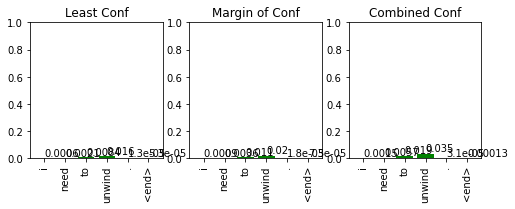

In [209]:
show_mismatches_in_percentile_range_results(0,10,15)

## Conclusion and Thanks!
The above confirms the hypothesis that these scores can be used for modelling not only uncertainty, but acuracy, and drive further analysis and uncertainty sampling iterations. 


**Some next steps:**
  - ignore end of sentence token for aggregate certainty score
  - try Entropy score? - not sure that will tell us more than what we have here but may surprise us
  - try longer sentences
  - try different base in a custom softmax function (per Robert Munro)
  - Reverse source and target (non-English targets)
  - try aggregation by minimum token confidence in sequence
  - use another algorithm (e.g. Transformers)

